In [1]:
import torch 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns 
import pandas as pd 
from mutedpy.experiments.streptavidin.streptavidin_loader import *
from sklearn.metrics import r2_score
from mutedpy.experiments.streptavidin.streptavidin_loader import tobias_colors

In [2]:
aa_predictions_round_2 = pd.read_csv("../../../mutedpy/experiments/streptavidin/active_learning_2/AA_model/lists/predictions-aa.csv")

In [3]:
# load the proposed scheme
selection = pd.read_csv("../../../mutedpy/experiments/streptavidin/active_learning_2/AA_model/lists/safe+balanced-aa.csv")['variant']

In [4]:
# Lets pick top prediction from round_2

In [5]:
top_predictions = aa_predictions_round_2.head(240)['variant']

In [6]:
from mutedpy.protein_learning.kernels.blosum_kernel import blosum_kernel 
from mutedpy.protein_learning.kernels.hamming_kernel import hamming_kernel
from mutedpy.protein_learning.kernels.onehot_kernel import onehot_kernel

In [7]:
# load model 
from mutedpy.experiments.streptavidin.active_learning.compare_different_models import load_model
from mutedpy.utils.protein_operator import ProteinOperator
Op = ProteinOperator()
model_params = "/../../../mutedpy/experiments/streptavidin/active_learning_2/AA_model/params/final_model_params.p"
GP, embed, paramns = load_model(model_params, "second round fit", vintage = True, model_params_return = True)
#GP.feature_loader.feature_loaders[0].stacking = False

2023-10-11 10:49:25.625731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 10:49:25.768074: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 10:49:26.281130: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-11 10:49:26.281285: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

dict_keys(['feature_mask', 'feature_names', 'kernel', 'kernel_object', 'ard_gamma', 'noise_std', 'x', 'y', 'feature_loader', 'Sigma'])
Fitting second round fit
{'kappa': 3.0, 'group': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'ard_gamma': tensor([ 7.8137e+00,  5.4357e+00,  2.8166e+00,  2.8939e+00,  4.1474e+01,
         3.6573e+00,  9.8912e+00,  4.7052e+00,  5.3773e+00,  6.5864e+00,
         1.4200e+01, -2.0355e+00,  1.0914e+05,  5.0735e+00,  5.8495e-01,
         7.0306e+00,  1.2471e+01,  2.6259e+00,  4.2813e+00,  5.3976e+00],
       dtype=torch.float64), 'nu': 2.5}
Amino-acids embedding loaded.


In [8]:
def calculate_div_score(variants):
    x = embed(torch.from_numpy(Op.translate_mutation_series(variants)))
    _, K_opt = GP.mean_std(x, full=True)
    n = len(variants)
    #print (K_opt)
    print (torch.linalg.slogdet(K_opt))
    return float(torch.exp(torch.linalg.slogdet(K_opt)[1]*(1./n) - np.log(torch.trace(K_opt)/n)))

In [9]:
td = calculate_div_score(top_predictions)

torch.return_types.linalg_slogdet(
sign=tensor(1., dtype=torch.float64),
logabsdet=tensor(-2041.3616, dtype=torch.float64))


In [10]:
sd = calculate_div_score(selection)

torch.return_types.linalg_slogdet(
sign=tensor(1., dtype=torch.float64),
logabsdet=tensor(-1465.4358, dtype=torch.float64))


In [11]:
def calculate_div_score_custom_kernel(kernel, variants):
    n = len(variants)
    K_opt = kernel(variants, variants) + GP.s * torch.eye(n).double()
    return float(torch.exp(torch.linalg.slogdet(K_opt)[1]*(1./n) - np.log(torch.trace(K_opt)/n)))

In [12]:
tb, sb = calculate_div_score_custom_kernel(blosum_kernel, top_predictions), calculate_div_score_custom_kernel(blosum_kernel, selection)

In [13]:
th, sh = calculate_div_score_custom_kernel(onehot_kernel, top_predictions), calculate_div_score_custom_kernel(onehot_kernel, selection)

In [14]:
ratiod = sd/td
ratiob = sb/tb
ratioh = sh/th

In [15]:
ratioh

1.0883119296341315

In [16]:
ratiod

20.19928295603973

In [17]:
data_frame = pd.DataFrame(data = {'Diversity score':[tb,sb,td,sd,th,sh],'Diversity type':['BLOSUM','BLOSUM','GP','GP','Hamming','Hamming'],'Batch':['TopX','Our selection','TopX','Our selection','TopX','Our selection']})

In [18]:
data_frame["log Diversity score"] = -np.log(data_frame["Diversity score"])

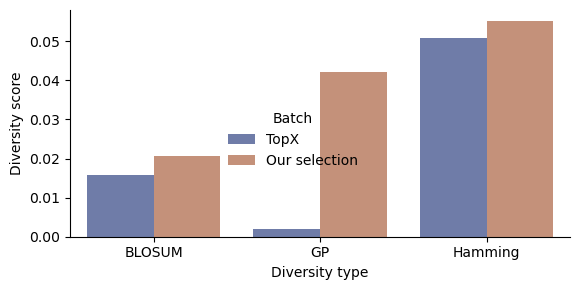

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.catplot(
    data=data_frame, kind="bar",
    x="Diversity type", y="Diversity score", hue="Batch", palette="dark", alpha=.6, height =3, aspect=2)
g._legend.set_bbox_to_anchor((0.5, 0.5))

for e,ratio in enumerate([ratiob, ratiod, ratioh]):
    ax = g.ax
    ax.annotate("+"+str(-int(100-100*(ratio))) +"%",
                xy=(0.2+e, 0.1), xycoords='data',
                xytext=(-0.2+e, 0.05), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
    
plt.savefig("diversity.pdf",dpi = 200,bbox_inches='tight')
plt.show()
